In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

In [30]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [31]:
from torchmetrics.classification import CalibrationError

def calculate_ece(predictions, labels, n_bins=10):
    ece_metric = CalibrationError(n_bins=n_bins, norm='l1', task="multiclass", num_classes=4)
    
    predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
    labels_tensor = torch.tensor(labels)
    
    ece = ece_metric(predictions_tensor, labels_tensor)
    
    return ece.item()

# Load model

In [32]:
import torch
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM

# model_id = "meta-llama/Meta-Llama-3-8B"
# model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_id = "huggyllama/llama-7b"
# model_id = "facebook/opt-13b"
model_id = "meta-llama/Llama-2-7b-hf"


tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    output_hidden_states=True,
    device_map="auto",
    torch_dtype=torch.float16,
)


/home/djaniak/mambaforge/envs/info/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Load dataset

Please pick one among the available configs: 
['abstract_algebra', 'all', 'anatomy', 'astronomy', 'auxiliary_train', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehistory', 'professional_accounting', 'professional_law', 'professional_medicine', 'professional_psychology', 'public_relations', 'security_studies', 'sociology', 'us_foreign_policy', 'virology', 'world_religions']

In [6]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/imdb")

Using the latest cached version of the dataset since stanfordnlp/imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /home/djaniak/.cache/huggingface/datasets/stanfordnlp___imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Fri Jul 26 14:18:31 2024).


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
dataset["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

# Train linear probing classifier on top of the hidden states

In [9]:
from tqdm import tqdm
from collections import defaultdict


def extract_data(dataset, model, tokenizer, device, text_column, target_column, aggregate = "mean"):
    X = defaultdict(list)
    y = []

    for example in tqdm(dataset):
        inputs = tokenizer(example[text_column], return_tensors='pt', truncation=True, max_length=2048).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            for i, hs in enumerate(outputs.hidden_states):
                if aggregate == "mean":
                    X[i].append(hs.squeeze().mean(dim=0).cpu())
                elif aggregate == "last_token":
                    X[i].append(hs.squeeze()[-1,:].cpu())
                else:
                    raise ValueError(f"Unknown aggregation method: {aggregate}")
            y.append(example[target_column])

    for k, v in X.items():
        X[k] = torch.stack(v)

    return X, y


In [10]:
text_column = 'text'
target_column = 'label'
aggregate = 'mean'
N = 5000

tr_features, tr_labels = extract_data(dataset['train'].shuffle(seed=42).select(range(N)), model, tokenizer, device, text_column, target_column)
te_features, te_labels = extract_data(dataset['test'].shuffle(seed=42).select(range(N//5)), model, tokenizer, device, text_column, target_column)

100%|██████████| 1000/1000 [01:14<00:00, 13.49it/s]


In [11]:
tr_features[0].shape, te_features[0].shape, len(tr_labels), len(te_labels)

(torch.Size([5000, 4096]), torch.Size([1000, 4096]), 5000, 1000)

In [27]:
import numpy as np


np.unique(tr_labels, return_counts=True)

(array([0, 1]), array([2494, 2506]))

In [23]:
from sklearn.linear_model import LogisticRegression
from torchmetrics.classification import BinaryCalibrationError
from sklearn.metrics import accuracy_score

bce = BinaryCalibrationError(n_bins=10, norm='l1')

results = []

for i, (tr_feat, te_feat) in enumerate(zip(tr_features.values(), te_features.values())):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(tr_feat, tr_labels)

    tr_probs = lr.predict_proba(tr_feat)
    tr_pred = np.argmax(tr_probs, axis=1)
    # tr_pred = lr.predict(tr_feat)
    tr_acc = round(accuracy_score(tr_labels, tr_pred), 3)
    tr_ece = round(bce(torch.tensor(tr_probs)[:,1], torch.tensor(tr_labels)).item(), 3)

    te_probs = lr.predict_proba(te_feat)
    te_pred = np.argmax(te_probs, axis=1)
    te_acc = round(accuracy_score(te_pred, te_labels), 3)
    te_ece = round(bce(torch.tensor(te_probs)[:,1], torch.tensor(te_labels)).item(), 3)

    results.append((tr_acc, tr_ece, te_acc, te_ece))
    print(f"Block {i}th; train - acc: {tr_acc}, ece {tr_ece}; test - acc: {te_acc}, ece: {te_ece}")



Block 0th; train - acc: 0.729, ece 0.206; test - acc: 0.699, ece: 0.177
Block 1th; train - acc: 0.767, ece 0.196; test - acc: 0.728, ece: 0.159
Block 2th; train - acc: 0.798, ece 0.156; test - acc: 0.761, ece: 0.123
Block 3th; train - acc: 0.842, ece 0.137; test - acc: 0.809, ece: 0.114
Block 4th; train - acc: 0.881, ece 0.111; test - acc: 0.849, ece: 0.092
Block 5th; train - acc: 0.918, ece 0.08; test - acc: 0.874, ece: 0.064
Block 6th; train - acc: 0.935, ece 0.066; test - acc: 0.899, ece: 0.048
Block 7th; train - acc: 0.951, ece 0.057; test - acc: 0.912, ece: 0.038
Block 8th; train - acc: 0.961, ece 0.045; test - acc: 0.927, ece: 0.026
Block 9th; train - acc: 0.972, ece 0.041; test - acc: 0.937, ece: 0.023
Block 10th; train - acc: 0.978, ece 0.036; test - acc: 0.949, ece: 0.026
Block 11th; train - acc: 0.984, ece 0.031; test - acc: 0.95, ece: 0.012
Block 12th; train - acc: 0.986, ece 0.028; test - acc: 0.95, ece: 0.016
Block 13th; train - acc: 0.989, ece 0.028; test - acc: 0.951, ec

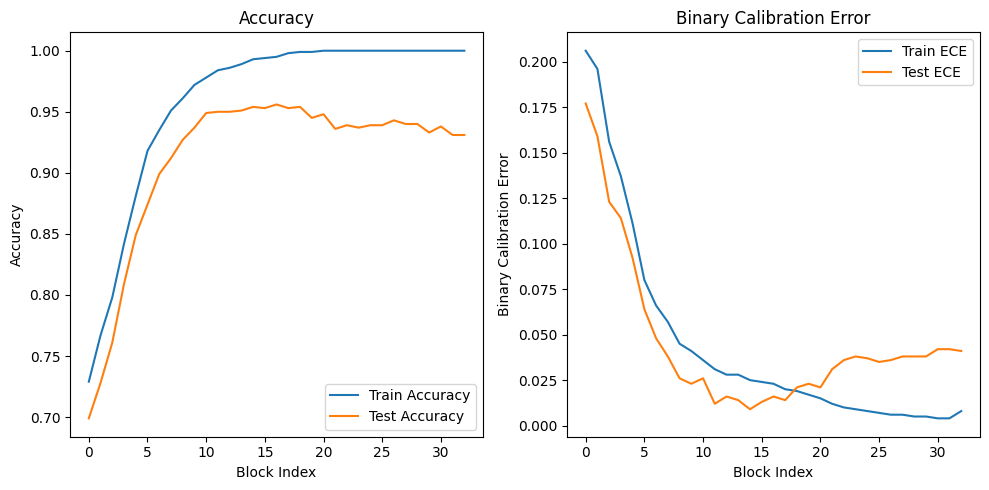

In [24]:
import matplotlib.pyplot as plt

# Extract the results
tr_accs = [result[0] for result in results]
tr_eces = [result[1] for result in results]
te_accs = [result[2] for result in results]
te_eces = [result[3] for result in results]

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(results)), tr_accs, label='Train Accuracy')
plt.plot(range(len(results)), te_accs, label='Test Accuracy')
plt.xlabel('Block Index')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(results)), tr_eces, label='Train ECE')
plt.plot(range(len(results)), te_eces, label='Test ECE')
plt.xlabel('Block Index')
plt.ylabel('Binary Calibration Error')
plt.title('Binary Calibration Error')
plt.legend()

plt.tight_layout()
plt.show()

# entropy

In [ ]:
from src.matrix_entropy import compute_entropies_for_each_sentence
from torch.utils.data import DataLoader

def get_dataloader(dataset, target_column, remove_columns, max_length=2048, seed=42):
    def tokenize_function(examples):
        return tokenizer(examples[target_column], truncation=True, max_length=max_length)

    tokenized_dataset = dataset.map(tokenize_function, batched=True).shuffle(seed=seed)
    tokenized_dataset = tokenized_dataset.remove_columns(remove_columns)
    tokenized_dataset.set_format("torch")

    dataloader = DataLoader(tokenized_dataset, shuffle=False)
    return dataloader

remove_columns = ["text", "label"]
target_column = "text"

tr_dataloader = get_dataloader(dataset['train'].shuffle(seed=42).select(range(N)), target_column, remove_columns)
te_dataloader = get_dataloader(dataset['test'].shuffle(seed=42).select(range(N//5)), target_column, remove_columns)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tr_entropies = compute_entropies_for_each_sentence(
    model, tr_dataloader, alpha=1, device=device
)
te_entropies = compute_entropies_for_each_sentence(
    model, te_dataloader, alpha=1, device=device
)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


In [ ]:
from src.utils import get_metric


def get_mean_entropies(entropies):
    mean_entropies = {}
    hidden_states = entropies["unnormalized_entropy"].keys()
    for e in [
                "logN_normalized_entropy",
                "logD_normalized_entropy",
                "NlogD_normalized_entropy",
                "logNlogD_normalized_entropy",
            ]:
        es = []
        for hs in hidden_states:
            es.append(np.mean(get_metric(entropies, e, hidden_state=hs)))
        mean_entropies[e] = es
    return mean_entropies

mean_tr_entropies = get_mean_entropies(tr_entropies)
mean_te_entropies = get_mean_entropies(te_entropies)




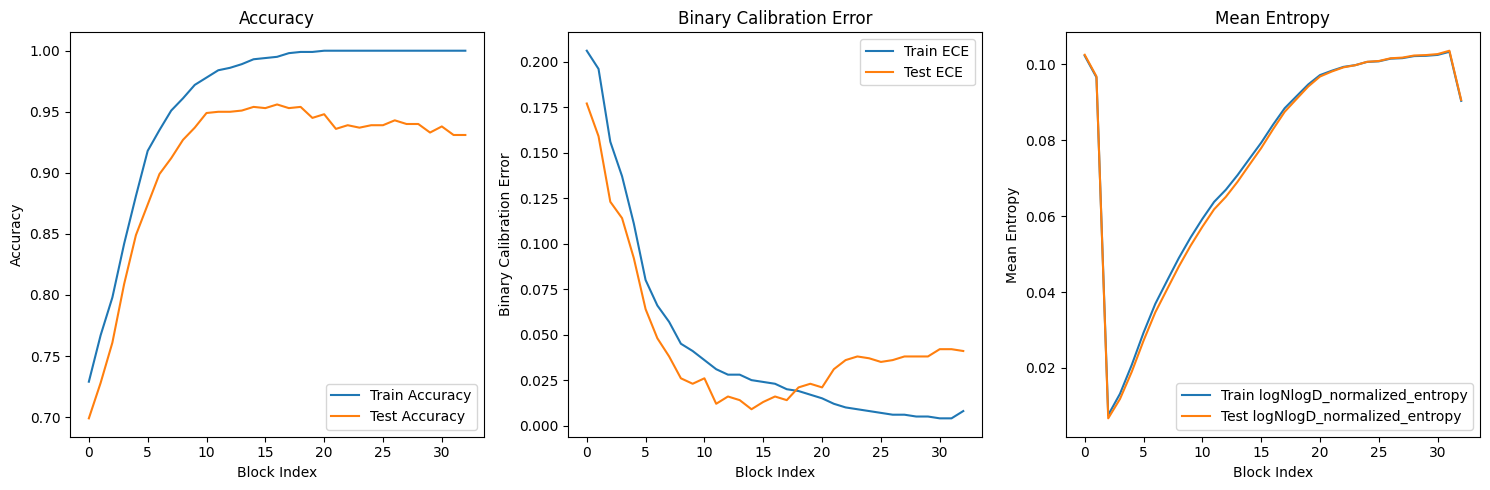

In [ ]:
import matplotlib.pyplot as plt

# Extract the results
tr_accs = [result[0] for result in results]
tr_eces = [result[1] for result in results]
te_accs = [result[2] for result in results]
te_eces = [result[3] for result in results]

# Plot the results
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(range(len(results)), tr_accs, label='Train Accuracy')
plt.plot(range(len(results)), te_accs, label='Test Accuracy')
plt.xlabel('Block Index')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot Binary Calibration Error
plt.subplot(1, 3, 2)
plt.plot(range(len(results)), tr_eces, label='Train ECE')
plt.plot(range(len(results)), te_eces, label='Test ECE')
plt.xlabel('Block Index')
plt.ylabel('Binary Calibration Error')
plt.title('Binary Calibration Error')
plt.legend()

# Plot Mean Entropies
plt.subplot(1, 3, 3)
entropy = "logNlogD_normalized_entropy"
plt.plot(range(len(mean_tr_entropies[entropy])), mean_tr_entropies[entropy], label=f'Train {entropy}')
plt.plot(range(len(mean_te_entropies[entropy])), mean_te_entropies[entropy], label=f'Test {entropy}')
plt.xlabel('Block Index')
plt.ylabel('Mean Entropy')
plt.title('Mean Entropy')
plt.legend()

plt.tight_layout()
plt.show()

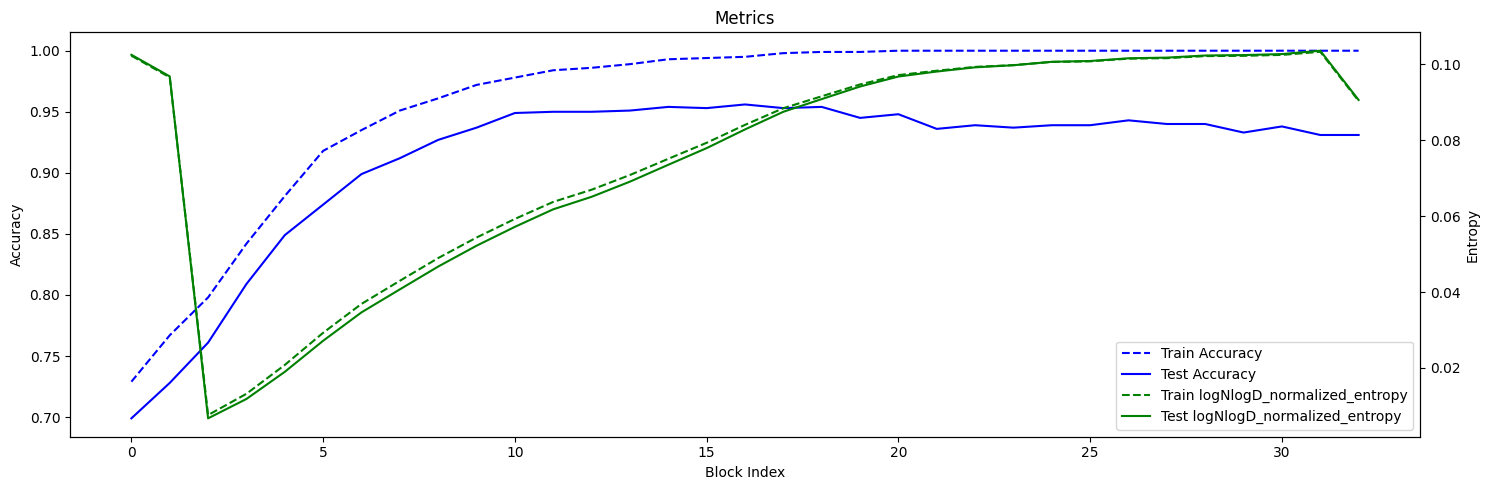

In [ ]:
# Plot the results
fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()

# Plot Accuracy
ax1.plot(range(len(results)), tr_accs, label='Train Accuracy', linestyle='--', color='blue')
ax1.plot(range(len(results)), te_accs, label='Test Accuracy', linestyle='-', color='blue')

# Plot Mean Entropies
entropy = "logNlogD_normalized_entropy"
ax2.plot(range(len(mean_tr_entropies[entropy])), mean_tr_entropies[entropy], label=f'Train {entropy}',linestyle='--', color='green')
ax2.plot(range(len(mean_te_entropies[entropy])), mean_te_entropies[entropy], label=f'Test {entropy}', color='green')

ax1.set_xlabel('Block Index')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Entropy')
plt.title('Metrics')

ax1.tick_params(axis='y')

ax2.tick_params(axis='y')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.tight_layout()
plt.show()

# Last token aggregation

In [47]:
from tqdm import tqdm
from collections import defaultdict


def extract_data(dataset, model, tokenizer, device, text_column, target_column, aggregate = "mean"):
    X = defaultdict(list)
    y = []

    for example in tqdm(dataset):
        inputs = tokenizer(example[text_column], return_tensors='pt', truncation=True, max_length=2048).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            for i, hs in enumerate(outputs.hidden_states):
                if aggregate == "mean":
                    X[i].append(hs.squeeze().mean(dim=0).cpu())
                elif aggregate == "last_token":
                    X[i].append(hs.squeeze()[-10:,:].mean(dim=0).cpu())
                else:
                    raise ValueError(f"Unknown aggregation method: {aggregate}")
            y.append(example[target_column])

    for k, v in X.items():
        X[k] = torch.stack(v)

    return X, y


In [48]:
text_column = 'text'
target_column = 'label'
aggregate = 'last_token'
N = 5000

tr_features, tr_labels = extract_data(dataset['train'].shuffle(seed=42).select(range(N)), model, tokenizer, device, text_column, target_column, aggregate)
te_features, te_labels = extract_data(dataset['test'].shuffle(seed=42).select(range(N//5)), model, tokenizer, device, text_column, target_column, aggregate)

  0%|          | 2/5000 [00:00<04:13, 19.73it/s]

 13%|█▎        | 628/5000 [00:48<05:02, 14.45it/s]

In [33]:
for example in tqdm(dataset['train'].shuffle(seed=42).select(range(N))):
    inputs = tokenizer(example[text_column], return_tensors='pt', truncation=True, max_length=2048).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        for i, hs in enumerate(outputs.hidden_states):
            break
    break

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


In [36]:
hs.squeeze().shape

torch.Size([178, 4096])

In [34]:
hs.squeeze().mean(dim=0).cpu().shape

torch.Size([4096])

In [37]:
hs.squeeze()[-10:,:].cpu().shape

torch.Size([10, 4096])

In [38]:
hs.squeeze()[-10:,:].cpu()

tensor([[-0.0003,  0.0088, -0.0028,  ...,  0.0032,  0.0089, -0.0050],
        [ 0.0253, -0.0047,  0.0161,  ...,  0.0223,  0.0008, -0.0160],
        [-0.0054,  0.0012,  0.0083,  ...,  0.0112, -0.0043, -0.0077],
        ...,
        [ 0.0083, -0.0046,  0.0112,  ..., -0.0071, -0.0112, -0.0028],
        [-0.0243, -0.0058,  0.0010,  ...,  0.0104, -0.0140, -0.0026],
        [-0.0065,  0.0007,  0.0237,  ..., -0.0073,  0.0034,  0.0093]],
       dtype=torch.float16)

In [42]:
hs.squeeze()[-2:,:].cpu()


tensor([[-0.0243, -0.0058,  0.0010,  ...,  0.0104, -0.0140, -0.0026],
        [-0.0065,  0.0007,  0.0237,  ..., -0.0073,  0.0034,  0.0093]],
       dtype=torch.float16)

In [19]:
hs.shape

torch.Size([1, 178, 4096])

In [ ]:
from sklearn.linear_model import LogisticRegression
from torchmetrics.classification import BinaryCalibrationError
from sklearn.metrics import accuracy_score
import numpy as np

bce = BinaryCalibrationError(n_bins=10, norm='l1')

results = []

for i, (tr_feat, te_feat) in enumerate(zip(tr_features.values(), te_features.values())):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(tr_feat, tr_labels)

    tr_probs = lr.predict_proba(tr_feat)
    tr_pred = np.argmax(tr_probs, axis=1)
    # tr_pred = lr.predict(tr_feat)
    tr_acc = round(accuracy_score(tr_labels, tr_pred), 3)
    tr_ece = round(bce(torch.tensor(tr_probs)[:,1], torch.tensor(tr_labels)).item(), 3)

    te_probs = lr.predict_proba(te_feat)
    te_pred = np.argmax(te_probs, axis=1)
    te_acc = round(accuracy_score(te_pred, te_labels), 3)
    te_ece = round(bce(torch.tensor(te_probs)[:,1], torch.tensor(te_labels)).item(), 3)

    results.append((tr_acc, tr_ece, te_acc, te_ece))
    print(f"Block {i}th; train - acc: {tr_acc}, ece {tr_ece}; test - acc: {te_acc}, ece: {te_ece}")

Block 0th; train - acc: 0.501, ece 0.0; test - acc: 0.488, ece: 0.013
Block 1th; train - acc: 0.501, ece 0.0; test - acc: 0.488, ece: 0.013
Block 2th; train - acc: 0.502, ece 0.001; test - acc: 0.477, ece: 0.024
Block 3th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 4th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 5th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 6th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 7th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 8th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 9th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 10th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 11th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 12th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece: 0.019
Block 13th; train - acc: 0.501, ece 0.007; test - acc: 0.489, ece

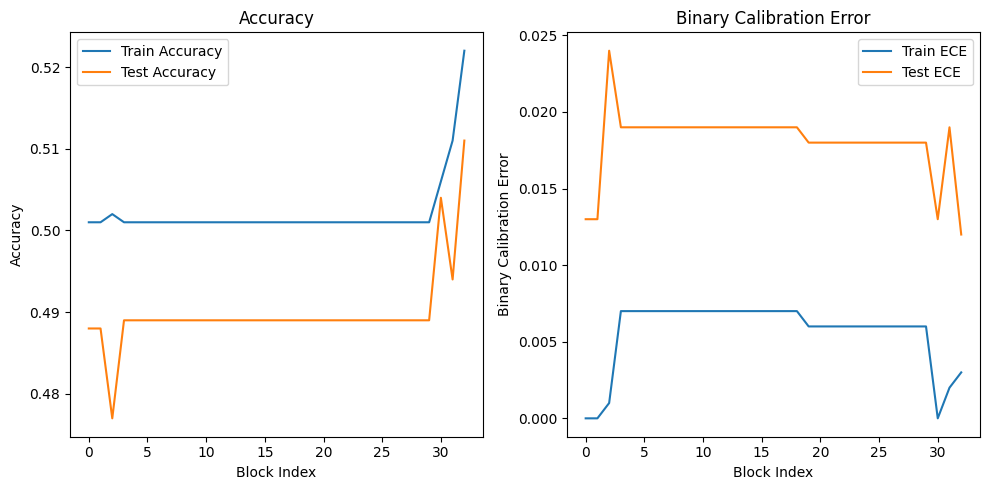

In [ ]:
import matplotlib.pyplot as plt

# Extract the results
tr_accs = [result[0] for result in results]
tr_eces = [result[1] for result in results]
te_accs = [result[2] for result in results]
te_eces = [result[3] for result in results]

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(results)), tr_accs, label='Train Accuracy')
plt.plot(range(len(results)), te_accs, label='Test Accuracy')
plt.xlabel('Block Index')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(results)), tr_eces, label='Train ECE')
plt.plot(range(len(results)), te_eces, label='Test ECE')
plt.xlabel('Block Index')
plt.ylabel('Binary Calibration Error')
plt.title('Binary Calibration Error')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
from sklearn.linear_model import LinearRegression

results = []

for i, (tr_feat, te_feat) in enumerate(zip(tr_features.values(), te_features.values())):
    lr = LinearRegression()
    lr.fit(tr_feat, tr_labels)

    tr_pred = lr.predict(tr_feat)
    


    te_pred = lr.predict(te_feat)
    te_acc = round(calculate_accuracy(te_pred, te_labels), 3)
    print(f"Train accuracy in {i}th block: {tr_acc}, Test accuracy in {i}th block: {te_acc}")

        # ece = calculate_ece(predictions, te_labels)
    # results.append(accuracy)

Train accuracy in 0th block: 0.003, Test accuracy in 0th block: 0.0
Train accuracy in 1th block: 0.003, Test accuracy in 1th block: 0.0
Train accuracy in 2th block: 0.011, Test accuracy in 2th block: 0.004
Train accuracy in 3th block: 0.006, Test accuracy in 3th block: 0.0
Train accuracy in 4th block: 0.025, Test accuracy in 4th block: 0.006
Train accuracy in 5th block: 0.016, Test accuracy in 5th block: 0.001
Train accuracy in 6th block: 0.016, Test accuracy in 6th block: 0.001
Train accuracy in 7th block: 0.003, Test accuracy in 7th block: 0.0
Train accuracy in 8th block: 0.032, Test accuracy in 8th block: 0.014
Train accuracy in 9th block: 0.003, Test accuracy in 9th block: 0.001
Train accuracy in 10th block: 0.012, Test accuracy in 10th block: 0.002
Train accuracy in 11th block: 0.003, Test accuracy in 11th block: 0.0
Train accuracy in 12th block: 0.003, Test accuracy in 12th block: 0.0
Train accuracy in 13th block: 0.003, Test accuracy in 13th block: 0.002
Train accuracy in 14th b

KeyboardInterrupt: 

---
# Other solutions

In [ ]:
import torch
from transformers import LlamaForCausalLM, LlamaTokenizer

prompt = """Question: Who was the first president of the United States? 

### 

Choices:
A. Barack Obama
B. George Washington
C. Michael Jackson
D. None of the above

###

Answer: """

inputs = tokenizer(prompt, return_tensors='pt').to('cuda')

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits[0, -1, :]

top_k = 100


probabilities = torch.softmax(logits, dim=-1)
top_k_probs, top_k_tokens = torch.topk(probabilities, top_k)


# aggregate probabilities for each choice
choice_probabilities = {
    'A': 0.0,
    'B': 0.0,
    'C': 0.0,
    'D': 0.0,
}
valid_tokens = {
    'A': ["A", "A."],
    'B': ["B", "B."],
    'C': ["C", "C."],
    'D': ["D", "D."],
}

# decode tokens and aggregate probabilities
for token, prob in zip(top_k_tokens, top_k_probs):
    token_str = tokenizer.decode([token]).strip()
    for choice, valid_list in valid_tokens.items():
        if token_str in valid_list:
            choice_probabilities[choice] += prob.item()
            break

# normalize 
total_sum = sum(choice_probabilities.values())
normalized_probabilities = {choice: prob / total_sum for choice, prob in choice_probabilities.items()}

for choice, agg_prob in normalized_probabilities.items():
    print(f"Aggregated normalized probability of choosing '{choice}': {agg_prob:.4f}")

conf = list(normalized_probabilities.values())
label = np.argmax(conf)

# print label and conf
print(f"Predicted label: {label}, Confidence: {max(conf):.4f}")

# for token, prob in zip(top_k_tokens, top_k_probs):
#     print(f"Token: {tokenizer.decode([token]).strip()}, Probability: {prob.item():.4f}")


Aggregated normalized probability of choosing 'A': 0.0257
Aggregated normalized probability of choosing 'B': 0.9297
Aggregated normalized probability of choosing 'C': 0.0120
Aggregated normalized probability of choosing 'D': 0.0327
Predicted label: 1, Confidence: 0.9297


In [ ]:
# apply softmax on values from choice_probabilities dict
import torch.nn.functional as F

torch.tensor(list(choice_probabilities.values()))

tensor([0.0083, 0.2928, 0.0039, 0.0103])

In [ ]:
total_sum = sum(choice_probabilities.values())
normalized_probabilities = {choice: prob / total_sum for choice, prob in choice_probabilities.items()}

print(normalized_probabilities)


{'A': 0.026428683995356094, 'B': 0.9286098642310763, 'C': 0.012279940257722374, 'D': 0.032681511515845224}


In [ ]:
torch.distributions.Categorical(torch.tensor(list(choice_probabilities.values()))).probs

tensor([0.0264, 0.9286, 0.0123, 0.0327])

In [ ]:
F.softmax(torch.tensor(list(choice_probabilities.values())), dim=0)

tensor([8.0133e-06, 9.9997e-01, 1.1016e-06, 1.8632e-05])

# Good solution (shiftting tokens one left to get next token probs)

In [ ]:
import torch
import numpy as np


# Define the prompt and choices
prompt = """Question: Who was the first president of the United States? 

### 

Choices:
A. Barack Obama
B. George Washington
C. Michael Jackson
D. None of the above

###

Answer:"""

choices = ["A. Barack Obama", "B. George Washington", "C. Michael Jackson", "D. None of the above"]


# Tokenize the prompt without the answer
prompt_tokens = tokenizer(prompt, return_tensors='pt').to("cuda")

# Function to calculate log-probability of a choice
def calculate_log_prob(prompt_tokens, choice):
    # Tokenize the full input (prompt + choice)
    choice_tokens = tokenizer(choice, return_tensors='pt').to("cuda")
    full_input_ids = torch.cat((prompt_tokens['input_ids'], choice_tokens['input_ids'][:, 1:]), dim=1)
    
    # Get model output
    with torch.no_grad():
        outputs = model(input_ids=full_input_ids)
    
    # Get logits and calculate log-probabilities for the choice tokens
    logits = outputs.logits[0, prompt_tokens['input_ids'].shape[1]-1:-1, :]  # Only the logits for the choice tokens
    print(logits.shape)

    log_probs = torch.log_softmax(logits, dim=-1)
    
    # Calculate the total log-probability for the choice
    total_log_prob = 0
    for i, token in enumerate(choice_tokens['input_ids'][0, 1:]):
        total_log_prob += log_probs[i, token].item()
    
    return total_log_prob

# Calculate log-probabilities for each choice
log_probs = [calculate_log_prob(prompt_tokens, choice) for choice in choices]

# Print the log-probabilities
for choice, log_prob in zip(choices, log_probs):
    print(f"Log-probability of '{choice}': {log_prob:.4f}")

# Generate the answer to check which choice the model generates
inputs = tokenizer(prompt, return_tensors='pt').to("cuda")
outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True)
generated_tokens = outputs.sequences[0, inputs.input_ids.shape[1]:]
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
print(f"Generated answer: {generated_text}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([4, 128256])
torch.Size([4, 128256])
torch.Size([4, 128256])
torch.Size([6, 128256])
Log-probability of 'A. Barack Obama': -19.7893
Log-probability of 'B. George Washington': -15.1474
Log-probability of 'C. Michael Jackson': -20.5238
Log-probability of 'D. None of the above': -20.0082
Generated answer:  B
